In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
path = "XRD/red_LCNO.txt"
df = pd.read_csv(path, delimiter = '\t')
df

,eV,counts/s
0,10.00356,0
1,10.01656,-51
2,10.02956,22
3,10.04256,-95
4,10.05556,-9
...,...,...
6149,89.94057,-125
6150,89.95357,-106
6151,89.96657,-64
6152,89.97957,-47


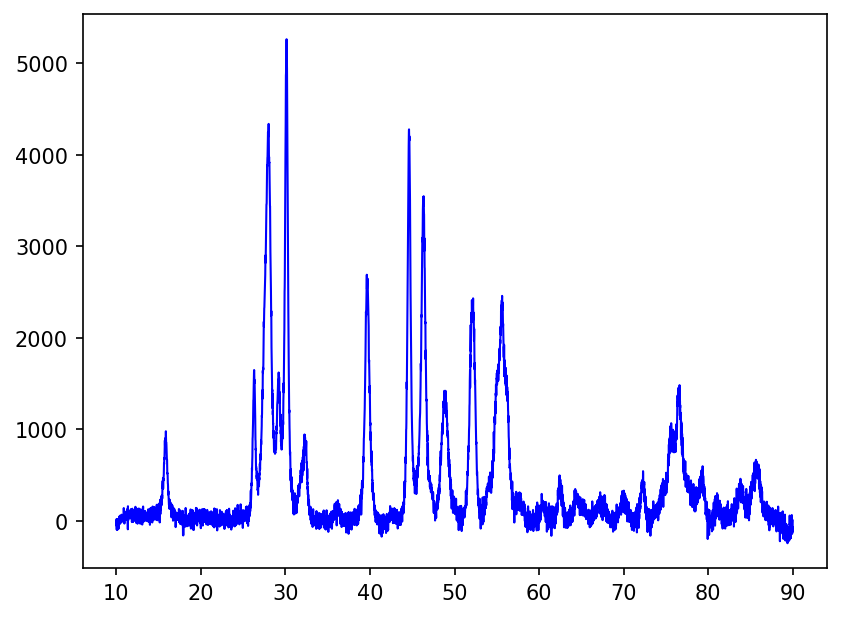

In [3]:
# set arrays
x = np.array(df['eV'])
y = np.array(df['counts/s'])

plt.figure(dpi = 150)
plt.plot(x, y, 'b-', lw = 1)

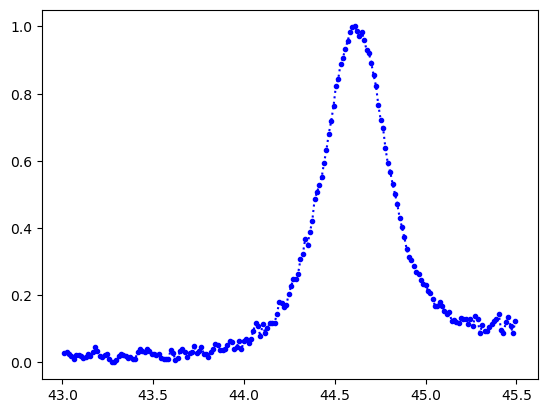

In [4]:
# define the area of 2θ for the desired peak
lower_lim = 43.0
upper_lim = 45.5

func = np.vectorize(lambda x: x>lower_lim and x<upper_lim)

y = y[func(x)]
x = x[func(x)]

# normalize data
y = (y-min(y))/(max(y)-min(y))

# set mean and standard deviation
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

plt.plot(x,y, 'b.:')

In [5]:
# define instrument parameters
Cu_K_alpha = 1.54178
instr_defect = 0.00000
shape_factor = 0.90

***Voigt fitting***

In [6]:
from lmfit.models import ExponentialModel, VoigtModel

In [7]:
exp_mod = ExponentialModel(prefix = 'exp_')
pars = exp_mod.guess(y, x = x)
    
voigt = VoigtModel(prefix = 'v_')
pars.update(voigt.make_params())
    
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
     
# where max is the value of the peak
pars['v_center'].set(value = mean, min = lower_lim, max = upper_lim)
pars['v_sigma'].set(value = sigma)
pars['v_amplitude'].set(value = max(y))

mod = voigt + exp_mod
    
init = mod.eval(pars, x = x)
out = mod.fit(y, pars, x = x)
    
comps = out.eval_components(x = x)

residual_Voigt = y - comps['v_']

print(out.fit_report(min_correl = 0.25))

[[Model]]
    (Model(voigt, prefix='v_') + Model(exponential, prefix='exp_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1291
    # data points      = 192
    # variables        = 5
    chi-square         = 0.03201933
    reduced chi-square = 1.7123e-04
    Akaike info crit   = -1660.19086
    Bayesian info crit = -1643.90338
[[Variables]]
    exp_amplitude:  1.8679e-26 +/- 8.7887e-26 (470.50%) (init = 4.448869e-33)
    exp_decay:     -0.80057654 +/- 0.06651667 (8.31%) (init = -0.6143452)
    v_amplitude:    0.53691766 +/- 0.00377299 (0.70%) (init = 1)
    v_center:       44.6143955 +/- 7.6835e-04 (0.00%) (init = 44.61536)
    v_sigma:        0.11663916 +/- 7.4101e-04 (0.64%) (init = 0.3693009)
    v_gamma:        0.11663916 +/- 7.4101e-04 (0.64%) == 'v_sigma'
    v_fwhm:         0.42005153 +/- 0.00162276 (0.39%) == '1.0692*v_gamma+sqrt(0.8664*v_gamma**2+5.545083*v_sigma**2)'
    v_height:       0.96073819 +/- 0.00466529 (0.49%) == '(v_amplitude/(max(1

In [8]:
# find x value at y maximum
corr_fwhm = out.params['v_fwhm'] - instr_defect
angle_rad_2θ = x[comps['v_'].argmax()]
angle_rad_θ = angle_rad_2θ/2
corr_fwhm_rad = np.pi*corr_fwhm/180
angle_rad_θ_rad = np.pi*angle_rad_θ/180

cryst_size_A = Cu_K_alpha*shape_factor/corr_fwhm_rad/np.cos(angle_rad_θ_rad)
cryst_size_nm = round(cryst_size_A/10, 0)
print("Crystal size in nm with Voigt fitting: {:.0f}".format(cryst_size_nm))

Crystal size in nm with Voigt fitting: 20


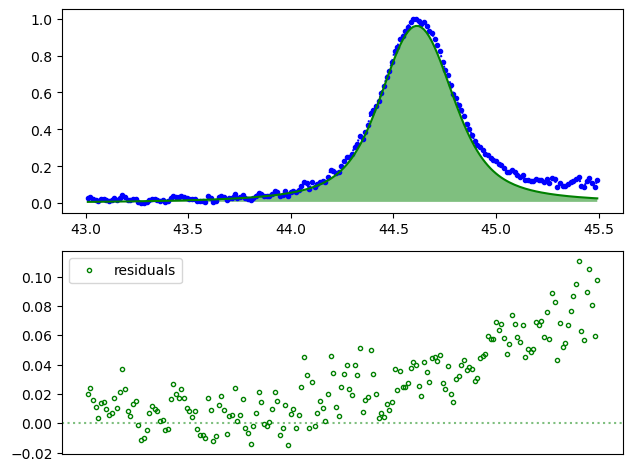

In [9]:
fig, axs = plt.subplots(nrows = 2, dpi = 100)

axs[0].plot(x, y, 'b.:', label = 'data')
axs[0].plot(x, comps['v_'], color = 'g', label = 'peak')
axs[0].fill_between(x, comps['v_'].min(), comps['v_'], facecolor = 'g', alpha=0.5)

axs[1].plot(x, residual_Voigt, ".", color = 'g', mfc = 'none', label = 'residuals') 
axs[1].legend()
axs[1].set_xticks([])
axs[1].axhline(y=0.00, color = 'g', linestyle = ':', alpha = 0.5)

fig.tight_layout()

***Gauss fitting***

In [10]:
from lmfit.models import ExponentialModel, GaussianModel

In [11]:
exp_mod = ExponentialModel(prefix = 'exp_')
pars = exp_mod.guess(y, x = x)
    
gauss = GaussianModel(prefix = 'g_')
pars.update(gauss.make_params())
    
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
     
# where max is the value of the peak
pars['g_center'].set(value = mean, min = lower_lim, max = upper_lim)
pars['g_sigma'].set(value = sigma)
pars['g_amplitude'].set(value = max(y))

mod = gauss + exp_mod
    
init = mod.eval(pars, x = x)
out = mod.fit(y, pars, x = x)
    
comps = out.eval_components(x = x)

residual_Gauss = y - comps['g_']

print(out.fit_report(min_correl = 0.25))

[[Model]]
    (Model(gaussian, prefix='g_') + Model(exponential, prefix='exp_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1833
    # data points      = 192
    # variables        = 5
    chi-square         = 0.08854927
    reduced chi-square = 4.7353e-04
    Akaike info crit   = -1464.88477
    Bayesian info crit = -1448.59729
[[Variables]]
    exp_amplitude:  5.1620e-15 +/- 9.3516e-15 (181.16%) (init = 4.448869e-33)
    exp_decay:     -1.47171995 +/- 0.08728503 (5.93%) (init = -0.6143452)
    g_amplitude:    0.40679650 +/- 0.00335419 (0.82%) (init = 1)
    g_center:       44.6127722 +/- 0.00129809 (0.00%) (init = 44.61536)
    g_sigma:        0.18233105 +/- 0.00143624 (0.79%) (init = 0.3693009)
    g_fwhm:         0.42935681 +/- 0.00338209 (0.79%) == '2.3548200*g_sigma'
    g_height:       0.89007511 +/- 0.00561758 (0.63%) == '0.3989423*g_amplitude/max(1e-15, g_sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(exp_amplitude, exp_d

In [12]:
# find x value at y maximum
corr_fwhm = out.params['g_fwhm'] - instr_defect
angle_rad_2θ = x[comps['g_'].argmax()]
angle_rad_θ = angle_rad_2θ/2
corr_fwhm_rad = np.pi*corr_fwhm/180
angle_rad_θ_rad = np.pi*angle_rad_θ/180
cryst_size_A = Cu_K_alpha*shape_factor/corr_fwhm_rad/np.cos(angle_rad_θ_rad)
cryst_size_nm = round(cryst_size_A/10, 0)
print("Crystal size in nm with Gauss fitting: {:.0f}".format(cryst_size_nm))

Crystal size in nm with Gauss fitting: 20


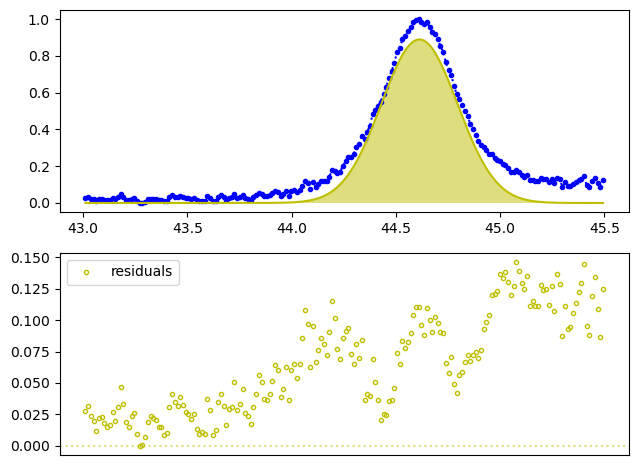

In [13]:
fig, axs = plt.subplots(nrows = 2, dpi = 100)

axs[0].plot(x, y, 'b.:', label = 'data')
axs[0].plot(x, comps['g_'], color = 'y', label = 'peak')
axs[0].fill_between(x, comps['g_'].min(), comps['g_'], facecolor = 'y', alpha=0.5)

axs[1].plot(x, residual_Gauss, ".", color = 'y', mfc = 'none', label = 'residuals') 
axs[1].legend()
axs[1].set_xticks([])
axs[1].axhline(y=0.00, color = 'y', linestyle = ':', alpha = 0.5)

fig.tight_layout()

***Lorentzian fitting***

In [14]:
from lmfit.models import ExponentialModel, LorentzianModel

In [15]:
exp_mod = ExponentialModel(prefix = 'exp_')
pars = exp_mod.guess(y, x = x)
    
lorentzian = LorentzianModel(prefix = 'l_')
pars.update(lorentzian.make_params())
    
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
     
# where max is the value of the peak
pars['l_center'].set(value = mean, min = lower_lim, max = upper_lim)
pars['l_sigma'].set(value = sigma)
pars['l_amplitude'].set(value = max(y))

mod = lorentzian + exp_mod
    
init = mod.eval(pars, x = x)
out = mod.fit(y, pars, x = x)
    
comps = out.eval_components(x = x)

residual_Lorentzian = y - comps['l_']

print(out.fit_report(min_correl = 0.25))

[[Model]]
    (Model(lorentzian, prefix='l_') + Model(exponential, prefix='exp_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5713
    # data points      = 192
    # variables        = 5
    chi-square         = 0.08446280
    reduced chi-square = 4.5167e-04
    Akaike info crit   = -1473.95637
    Bayesian info crit = -1457.66889
[[Variables]]
    exp_amplitude:  2.6526e-84 +/- 1.3358e-82 (5035.84%) (init = 4.448869e-33)
    exp_decay:     -0.23971877 +/- 0.06290412 (26.24%) (init = -0.6143452)
    l_amplitude:    0.63686156 +/- 0.00523604 (0.82%) (init = 1)
    l_center:       44.6176744 +/- 0.00126940 (0.00%) (init = 44.61536)
    l_sigma:        0.19729226 +/- 0.00197703 (1.00%) (init = 0.3693009)
    l_fwhm:         0.39458452 +/- 0.00395406 (1.00%) == '2.0000000*l_sigma'
    l_height:       1.02750782 +/- 0.00622486 (0.61%) == '0.3183099*l_amplitude/max(1e-15, l_sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(exp_amplitude, e

In [16]:
# find x value at y maximum
corr_fwhm = out.params['l_fwhm'] - instr_defect
angle_rad_2θ = x[comps['l_'].argmax()]
angle_rad_θ = angle_rad_2θ/2
corr_fwhm_rad = np.pi*corr_fwhm/180
angle_rad_θ_rad = np.pi*angle_rad_θ/180
cryst_size_A = Cu_K_alpha*shape_factor/corr_fwhm_rad/np.cos(angle_rad_θ_rad)
cryst_size_nm = round(cryst_size_A/10, 0)
print("Crystal size in nm with Lorentzian fitting: {:.0f}".format(cryst_size_nm))

Crystal size in nm with Lorentzian fitting: 22


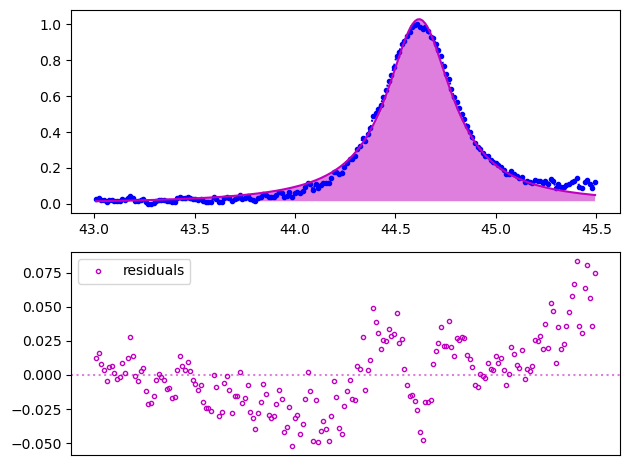

In [17]:
fig, axs = plt.subplots(nrows = 2, dpi = 100)

axs[0].plot(x, y, 'b.:', label = 'data')
axs[0].plot(x, comps['l_'], color = 'm', label = 'peak')
axs[0].fill_between(x, comps['l_'].min(), comps['l_'], facecolor = 'm', alpha=0.5)

axs[1].plot(x, residual_Lorentzian, ".", color = 'm', mfc = 'none', label = 'residuals') 
axs[1].legend()
axs[1].set_xticks([])
axs[1].axhline(y = 0.00, color = 'm', linestyle = ':', alpha = 0.5)

fig.tight_layout()